hmvec is able to create matter/pressure profiles and then calculate the power spectrum for the profiles. If we get a profile from data, then hmvec can be slightly edited to take this input and calculate power spectra for it (done in another notebook). However, if we are given a power spectra from data and want to find the profile, hmvec does not have a process to go backwards.

This notebook uses MCMC fitting methods to find a profile (defined by a set of parameters) given a power spectra. Each parameter set it wanders over defines a new profile, which is then calculated into a power spectrum, and compared to the given power spectrum. It finds the parameter set that gets the profile that calculates to the best fit power spectrum.

One of the current issues it faces are the lack of convergence, due to the degeneracy caused by the number of parameters and the lack of informed prior choices. The other issue is time, which can be circumvented for testing by shrinking the number of ms, ks, and nxs, but eventually will just have to be run on a cluster. With 2 seconds a step and ~1000 steps, the amount of time for each walker is around half an hour. With 90 walkers, the whole MCMC process takes about 2 days.

In [1]:
import os,sys
sys.path.append('../')
import camb
import hmvec as hm
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
import time

In [2]:
# Create model
zs = np.linspace(0.,3.,2)  # 20, DOES change MCMC time
ms = np.geomspace(2e10,1e17,20)  # 200, DOES change MCMC time
ks = np.geomspace(1e-4,100,1001)  # 1001, doesn't really change MCMC time
hcos = hm.HaloModel(zs,ks,ms=ms)

xmax = 20  # 20, doesn't really change MCMC time
nxs = 500  # 5000, DOES change MCMC Time

In [3]:
# Create density profile with preset parameter
hcos.add_battaglia_profile("electron",family="AGN",xmax=xmax,nxs=nxs, ignore_existing=True)


# Create new profile with different parameters
# The preset parameters are from battaglia_defaults['AGN'] found in the params.py file
parameters = {
    'rho0_A0': 8000,  # 4000
    'rho0_alpham': 0.5,  # 0.29
    'rho0_alphaz': -0.3,  # -0.66
    'alpha_A0': 0.5,  # 0.88
    'alpha_alpham': -0.07,  # -0.03
    'alpha_alphaz': 0.4,  # 0.19
    'beta_A0': 1.2,  # 3.83
    'beta_alpham': 0.08,  # 0.04
    'beta_alphaz': -0.045  # -0.025
}
hcos.add_battaglia_profile("electron_alt",family="AGN",xmax=xmax,nxs=nxs, \
                           param_override=parameters, ignore_existing=True)

/Volumes/Samsung_T5/Mac/Research/hmvec/Notebooks/../hmvec/fft.py:90: RuntimeWarning: invalid value encountered in true_divide
  uk = ukts/kts[None,None,:]/mnorm[...,None]


In [4]:
# Same but with pressure
hcos.add_battaglia_pres_profile("y",family='pres', xmax=xmax,nxs=nxs, ignore_existing=True)

pres_parameters = {
    'P0_A0' : 18.1,  # 18.1
    'P0_alpham' : 0.154,  # 0.154
    'P0_alphaz' : -0.758,  # -0.758
    'xc_A0' : 0.497,  # 0.497
    'xc_alpham' : -0.00865,  # -0.00865
    'xc_alphaz' : 0.731,  # 0.731
    'beta_A0' : 4.35,  # 4.35
    'beta_alpham' : 0.0393,  # 0.0393
    'beta_alphaz' : 0.415  # 0.415
}
hcos.add_battaglia_pres_profile("y_alt",family='pres', xmax=xmax,nxs=nxs, \
                                param_override=pres_parameters, ignore_existing=True)

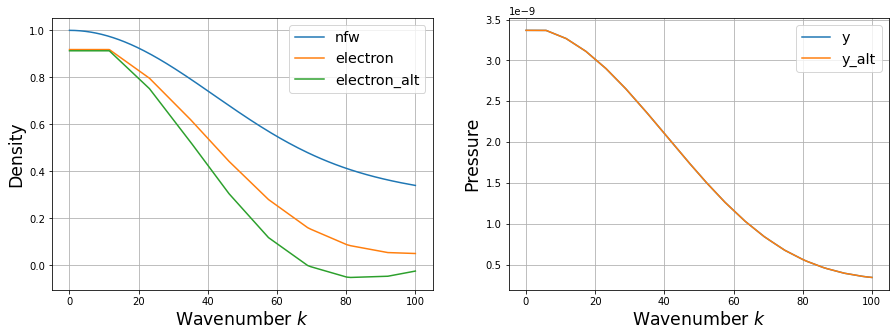

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.grid()
ax1.set_xlabel('Wavenumber $k$', fontsize='xx-large')
ax1.set_ylabel('Density', fontsize='xx-large')
for key in hcos.uk_profiles.keys():
    ax1.plot(ks, hcos.uk_profiles[key][0,0], label=key)
ax1.legend(fontsize='x-large')

ax2.grid()
ax2.set_xlabel('Wavenumber $k$', fontsize='xx-large')
ax2.set_ylabel('Pressure', fontsize='xx-large')
for key in hcos.pk_profiles.keys():
    ax2.plot(ks, hcos.pk_profiles[key][0,0], label=key)
ax2.legend(fontsize='x-large')

plt.show()

In [6]:
# Assign the data, errors, and parameter bounds

x = ks
# y = hcos.uk_profiles['electron1'][0,0]
# yerr = y * [0.05]
pee_1h = hcos.get_power_1halo(name="electron_alt")
y = pee_1h[0]
yerr = pee_1h[1]

ptrue = np.array([parameters['rho0_A0'],parameters['alpha_A0'] , parameters['beta_A0']])

parambounds = {
    'rho0_A0': parameters['rho0_A0'] * np.array([0.1, 10]),  # 4000
    'alpha_A0': parameters['alpha_A0'] * np.array([0.1, 10]),  # 0.88
    'beta_A0': parameters['beta_A0'] * np.array([0.1, 10]),  # 3.83
}

In [7]:
# Simple likelihood function
def log_likelihood(theta, x, y, yerr):
    rho0_A0, alpha_A0, beta_A0 = theta

    model_params = parameters.copy()
    model_params['rho_A0'] = rho0_A0
    model_params['alpha_A0'] = alpha_A0
    model_params['beta_A0'] = beta_A0
    hcos.add_battaglia_profile("model",family="AGN",xmax=xmax,nxs=nxs, \
                            param_override=model_params, ignore_existing=True)
    
#     model = hcos.uk_profiles['model'][0,0]
    model = hcos.get_power_1halo(name="model")[0]
    return -0.5 * np.sum((y - model) ** 2 / (yerr ** 2))

# Simple uniform priors
def log_prior(theta):
    rho0_A0, alpha_A0, beta_A0 = theta
    if list(parambounds.values())[0][0] < rho0_A0 < list(parambounds.values())[0][1] and \
    list(parambounds.values())[1][0] < alpha_A0 < list(parambounds.values())[1][1] and \
    list(parambounds.values())[2][0] < beta_A0 < list(parambounds.values())[2][1]:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [8]:
# Choose random starting points within the bounds

nwalkers = 20
ndim = len(parambounds)

pstarts = {}
for key in parambounds.keys():
    pstarts[key] = np.random.uniform(parambounds[key][0], parambounds[key][1], nwalkers)

pos=[]
for i in range(nwalkers):
    pos.append(np.array(list(pstarts.values()))[:,i])  
pos=np.array(pos)

# pos = np.array(list(parameters.values())) + np.random.randn(20, 9) * 1 \
#         * np.array([1000, 0.1, 0.1, 0.1, 0.01, 0.1, 1, 0.01, 0.01]) 
# nwalkers, ndim = pos.shape

In [9]:
# sampler = emcee.EnsembleSampler(
#     nwalkers, ndim, log_probability, args=(x, y, yerr)
# )
# sampler.run_mcmc(pos, 100, progress=True);

In [10]:
import multiprocessing
from multiprocessing import Pool

multiprocessing.set_start_method('fork', force=True)

with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr), pool=pool)
    sampler.run_mcmc(pos, 1000, progress=True);

/Volumes/Samsung_T5/Mac/Research/hmvec/Notebooks/../hmvec/fft.py:90: RuntimeWarning: invalid value encountered in true_divide
  uk = ukts/kts[None,None,:]/mnorm[...,None]
/Volumes/Samsung_T5/Mac/Research/hmvec/Notebooks/../hmvec/fft.py:90: RuntimeWarning: invalid value encountered in true_divide
  uk = ukts/kts[None,None,:]/mnorm[...,None]
/Volumes/Samsung_T5/Mac/Research/hmvec/Notebooks/../hmvec/fft.py:90: RuntimeWarning: invalid value encountered in true_divide
  uk = ukts/kts[None,None,:]/mnorm[...,None]
/Volumes/Samsung_T5/Mac/Research/hmvec/Notebooks/../hmvec/fft.py:90: RuntimeWarning: invalid value encountered in true_divide
  uk = ukts/kts[None,None,:]/mnorm[...,None]
/Volumes/Samsung_T5/Mac/Research/hmvec/Notebooks/../hmvec/fft.py:90: RuntimeWarning: invalid value encountered in true_divide
  uk = ukts/kts[None,None,:]/mnorm[...,None]
/Volumes/Samsung_T5/Mac/Research/hmvec/Notebooks/../hmvec/fft.py:90: RuntimeWarning: invalid value encountered in true_divide
  uk = ukts/kts[Non

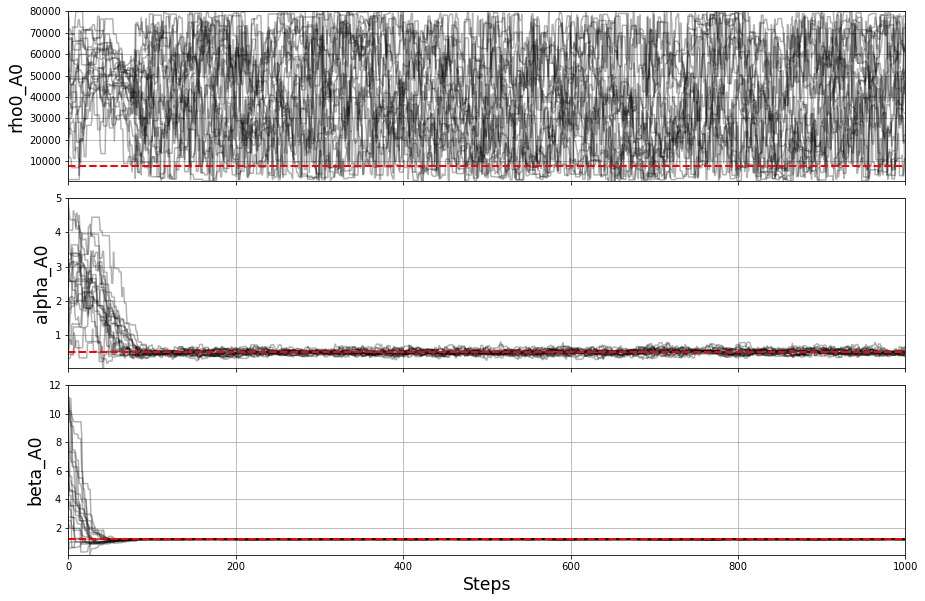

In [11]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 10), sharex=True)
samples = sampler.get_chain()
labels = list(parambounds.keys())
for i in range(ndim):
    ax = axes[i]

    ax.grid()
    ax.set_xlim(0, len(samples))
    ax.set_ylim(parambounds[labels[i]][0], parambounds[labels[i]][1])
    ax.set_ylabel(labels[i], fontsize='xx-large')
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.axhline(ptrue[i], lw=2, ls='--', color='r')
    #ax.yaxis.set_label_coords(-0.1, 0.5)

plt.xlabel("Steps", fontsize='xx-large')
plt.subplots_adjust(wspace=.4, hspace=.1)
plt.show()

In [12]:
tau = sampler.get_autocorr_time()
print(tau)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [35.90597597 44.58441442 17.44106698]

In [13]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(1200, 3)


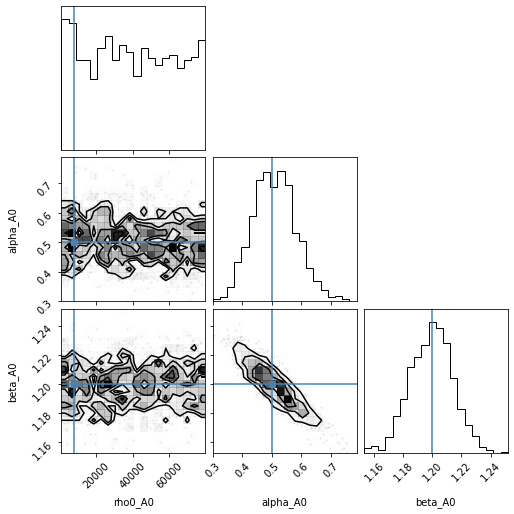

In [14]:
fig = corner.corner(
    flat_samples, labels=labels, truths=ptrue
);

In [15]:
params_mcmc = {}
params_err = {}

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    
    params_mcmc[list(parambounds.keys())[i]] = mcmc[1]
    params_err[list(parambounds.keys())[i]] = q

In [16]:
from IPython.display import display, Math

for i in range(ndim):
    parameter = list(parambounds.keys())[i]
    preal = ptrue[i]
    pmodel = params_mcmc[parameter]
    pup = params_err[parameter][1]
    pdown = params_err[parameter][0]
    if pmodel < preal:
        result = (preal-pmodel)/pup
    elif pmodel > preal:
        result = (pmodel-preal)/pdown
        
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}, \quad {4}"
    txt = txt.format(pmodel, pdown, pup, parameter, preal)
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [17]:
params_fit = parameters.copy()
params_fit['rho0_A0'] = params_mcmc['rho0_A0']
params_fit['alpha_A0'] = params_mcmc['alpha_A0']
params_fit['beta_A0'] = params_mcmc['beta_A0']



hcos.add_battaglia_profile("MCMCmodel",family="AGN",xmax=xmax,nxs=nxs, \
                            param_override=params_fit, ignore_existing=True)
MCMCmodel = hcos.uk_profiles['MCMCmodel'][0,0]

/Volumes/Samsung_T5/Mac/Research/hmvec/Notebooks/../hmvec/fft.py:90: RuntimeWarning: invalid value encountered in true_divide
  uk = ukts/kts[None,None,:]/mnorm[...,None]


In [18]:
inds = np.random.randint(len(flat_samples), size=100)

models, powermodels = [], []

for ind in inds:
    sample = flat_samples[ind]
    
    params_fit = parameters.copy()
    params_fit['rho0_A0'] = sample[0]
    params_fit['alpha_A0'] = sample[1]
    params_fit['beta_A0'] = sample[2]
    
    hcos.add_battaglia_profile("MCMCmodel1",family="AGN",xmax=xmax,nxs=nxs, \
                            param_override=params_fit, ignore_existing=True);
    powermodels.append(hcos.get_power_1halo(name="MCMCmodel1")[0])
    models.append(hcos.uk_profiles['MCMCmodel1'][0,0])
    
models, powermodels = np.array(models), np.array(powermodels)

In [19]:
topline, botline = [], []
toppowerline, botpowerline = [], []

for i in range(len(models[0])):
    topline.append(max(models[:,i]))
    botline.append(min(models[:,i]))
    toppowerline.append(max(powermodels[:,i]))
    botpowerline.append(min(powermodels[:,i]))

topline, botline = np.array(topline), np.array(botline)
toppowerline, botpowerline = np.array(toppowerline), np.array(botpowerline)

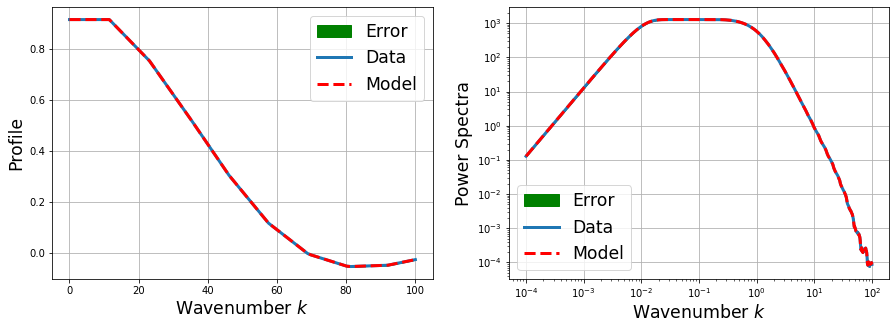

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.grid()
ax1.set_ylabel('Profile', fontsize='xx-large')
ax1.set_xlabel('Wavenumber $k$', fontsize='xx-large')

ax1.fill_between(ks, botline, topline, color='g', label='Error')
# for i in range(len(models)):
#     plt.plot(ks, models[i], alpha=0.1)

ax1.plot(ks, hcos.uk_profiles['electron_alt'][0,0], lw=3, label='Data')
ax1.plot(ks, MCMCmodel, color='r', ls='--', lw=3, label='Model')
ax1.legend(fontsize='xx-large')


ax2.grid()
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_ylabel('Power Spectra', fontsize='xx-large')
ax2.set_xlabel('Wavenumber $k$', fontsize='xx-large')


ax2.fill_between(ks, botpowerline, toppowerline, color='g', label='Error')
# for i in range(len(models)):
#     plt.plot(ks, models[i], alpha=0.1)

ax2.plot(ks, hcos.get_power_1halo(name="electron_alt")[0], lw=3, label='Data')
ax2.plot(ks, hcos.get_power_1halo(name="MCMCmodel")[0], color='r', ls='--', lw=3, label='Model')
ax2.legend(fontsize='xx-large')

plt.show()